<a href="https://github.com/labrijisaad/Energy-Forecast-API/blob/main/notebooks/API - Energy_Forecasting.ipynb" target="_blank">
  <img src="https://img.shields.io/badge/Open%20in-GitHub-blue.svg" alt="Open In GitHub"/>
</a>

# <center><a><span style="color:blue">`API` - Energy Forecasting Dataset</span></a></center>

Now that we've prepared our data, experimented with training machine learning models, and analyzed feature importance, we're ready to take our project a step further. By employing Object-Oriented Programming (OOP), we will **develop a class that simulates an API**. This API will serve two main purposes:

- **Short-term Predictions (`1-Day`):** Our goal is to facilitate **next-day** forecasts. [Explore `1-Day` API Future Predictions](#1-Day).

- **Long-term Predictions (`30-Day`):** Our aim extends to providing **month-ahead** forecasts. [Explore `30-Day` API Future Predictions](#30-Day).

Note: This **class-based API** is designed to **intake a DataFrame**, automatically train on the provided data, and offer predictions for both the **short-term** and **long-term**, depending on the user's needs.

### Import the needed libraries

In [1]:
# Supress warnings
import warnings ; warnings.filterwarnings('ignore')

# Data manipulation
import numpy as np
import pandas as pd

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns ; color_pal = sns.color_palette("husl", 9) ; plt.style.use('fivethirtyeight')

# Machine Learning
from sklearn.ensemble import RandomForestRegressor

# Utilities
from datetime import datetime, timedelta
from tqdm import tqdm

#### Load Processed Data

In [2]:
weather_and_consumption_df = pd.read_csv('../data/processed/weather_and_consumption.csv', index_col=0, parse_dates=True)
weather_and_consumption_df.head(1)

,total_consumption,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3,tempmax,tempmin,temp,...,conditions_rain,conditions_rainovercast,conditions_rainpartiallycloudy,conditions_snowovercast,conditions_snowpartiallycloudy,conditions_snowrain,conditions_snowrainovercast,conditions_snowrainpartiallycloudy,day_length,is_holiday
2006-12-16,1209.176,34.922,93552.53,5180.8,0.0,546.0,4926.0,8.2,3.4,5.7,...,False,False,True,False,False,False,False,False,8.278889,False


# <a><span style="color:red">`API` - Base Energy Model</span></a>

In [3]:
class BaseEnergyModel:
    """
    A base model for predicting energy consumption using RandomForestRegressor.

    Attributes:
        df (pd.DataFrame): The DataFrame containing the data for model training.
        column_names (list): List of column names to be used as predictors.
        external_features (list): List of external features to be used in the model.
        lags (list): List of integers representing the lag values for creating lag features.
        window_sizes (list): List of integers representing window sizes for creating rolling mean features.
        model (RandomForestRegressor): The Random Forest model for prediction.
        created_features (list): List of created feature names after feature engineering.
    """
    def __init__(self, df, column_names, external_features, lags, window_sizes, n_estimators=600, max_depth=3):
        """
        Initializes the model with data and training parameters.

        Args:
            df (pd.DataFrame): The dataset to be used for training the model.
            column_names (list): Names of the columns to predict.
            external_features (list): Names of external predictor variables.
            lags (list): Lag periods for generating lagged features.
            window_sizes (list): Window sizes for generating rolling features.
            n_estimators (int, optional): The number of trees in the forest. Defaults to 600.
            max_depth (int, optional): The maximum depth of the tree. Defaults to 3.
        """
        self.df = df
        self.column_names = column_names
        self.external_features = external_features
        self.lags = lags
        self.window_sizes = window_sizes
        self.model = RandomForestRegressor(n_estimators=n_estimators, max_depth=max_depth)
        self.created_features = []
        self._create_features()
        self._train()

    def plot_feature_importance(self, top_n=10):
        """
        Plots the top N feature importances of the trained RandomForestRegressor model using Seaborn.
        Args:
        - top_n (int): Number of top features to plot.
        """
        # Ensure the model has been trained before plotting
        if not hasattr(self, 'model') or not hasattr(self.model, 'feature_importances_'):
            print("Model must be trained before plotting feature importances.")
            return
        
        features = self.created_features + self.external_features
        importances = self.model.feature_importances_
        
        # Create DataFrame for feature importances
        feature_data = pd.DataFrame({
            'Feature': features,
            'Importance': importances
        }).sort_values(by='Importance', ascending=False).head(top_n)
        
        # Plotting
        plt.figure(figsize=(20, 5))
        sns.barplot(data=feature_data, x='Importance', y='Feature', palette='viridis')
        
        # Adding titles and labels
        model_type = "Short-Term" if isinstance(self, ShortTermEnergyModel) else "Long-Term"
        plt.title(f'{model_type} Model: Top {top_n} Features', fontsize=16)
        plt.xlabel('Feature Importance', fontsize=12)
        plt.ylabel('Feature', fontsize=12)
        
        # Adjust layout and display the plot
        plt.tight_layout()
        plt.show()

    def _create_features(self):
        """
        Performs feature engineering to create lagged and rolling mean features.
        """
        self.df['dayofweek'] = self.df.index.dayofweek
        self.created_features.append('dayofweek')

        for column_name in self.column_names:
            for lag in self.lags:
                feature_name = f"{column_name}_lag_{lag}"
                self.df[feature_name] = self.df[column_name].shift(lag)
                self.created_features.append(feature_name)

            for window in self.window_sizes:
                feature_name = f"{column_name}_rolling_mean_{window}"
                self.df[feature_name] = self.df[column_name].shift(1).rolling(window=window).mean()
                self.created_features.append(feature_name)

    def _train(self):
        """
        Trains the RandomForestRegressor model on the engineered features.
        """
        features = self.created_features + self.external_features
        X_train = self.df[features].dropna()
        y_train = self.df[self.column_names[0]].loc[X_train.index]
        self.used_features = list(X_train.columns)
        self.model.fit(X_train, y_train)

    def predict_for_date(self, date):
        """
        Predicts total consumption for a specified date using the trained model.

        Args:
            date (str): The date for which to predict consumption, in 'YYYY-MM-DD' format.

        Returns:
            float: The predicted consumption value, or None if prediction cannot be made.
        """
        date = pd.to_datetime(date)

        if date not in self.df.index:
            print(f"No direct data available for {date}, prediction requires feature presence.")
            return None

        features_order = self.created_features + self.external_features
        X_test = self.df.loc[[date], features_order]

        if not X_test.empty:
            prediction = self.model.predict(X_test)
            return prediction[0]
        else:
            print("Features not available for prediction.")
            return None

# <a id='1-Day'><span style="color:green">`1-Day` API Future Predictions</span></a>

In [4]:
class ShortTermEnergyModel(BaseEnergyModel):
    """
    A model designed for short-term energy consumption forecasting.

    Args:
        df (pd.DataFrame): The DataFrame containing the data for model training and prediction.
    """
    def __init__(self, df):
        # Initialize the base class with specific parameters for short-term forecasting
        super().__init__(df,
                         column_names=['total_consumption', 'day_length', 'dayofweek'],
                         external_features=['day_length'],  
                         lags=[1, 2, 3, 4, 5, 6, 7, 30],
                         window_sizes=[2, 3, 4, 5, 6, 7, 30])

#### Usage

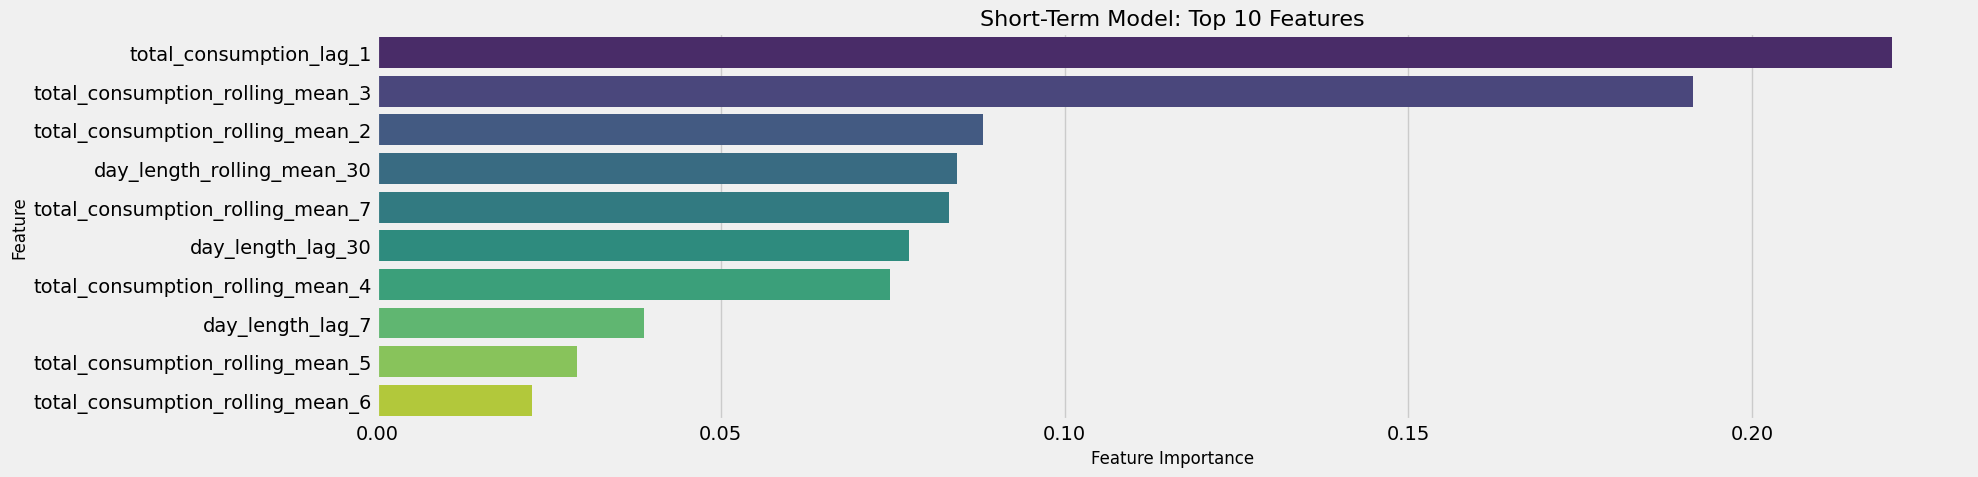

In [5]:
# Train the model on the 'weather_and_consumption_df' data
short_term_model = ShortTermEnergyModel(weather_and_consumption_df)

# Plot the Feature Importance
short_term_model.plot_feature_importance(top_n=10)

In [6]:
# Short-term prediction test
date = '2010-11-25'
short_term_pred = short_term_model.predict_for_date(date)
print(f"Predicted total consumption for {date}: {short_term_pred}")

Predicted total consumption for 2010-11-25: 1864.3511157565056


# <a id='30-Day'><span style="color:green">`30-Day` API Future Predictions</span></a>

In [7]:
class LongTermEnergyModel(BaseEnergyModel):
    """
    A model designed for long-term energy consumption forecasting.

    Args:
        df (pd.DataFrame): The DataFrame containing the data for model training and prediction.
    """
    def __init__(self, df):
        # Initialize the base class with specific parameters for long-term forecasting
        super().__init__(df,
                         column_names=['total_consumption', 'day_length'],
                         external_features=['feelslike', 'temp', 'day_length', 'tempmax'],
                         lags=[30, 40, 365], 
                         window_sizes=[])  # No moving averages are used, to prevent data leakage

#### Usage

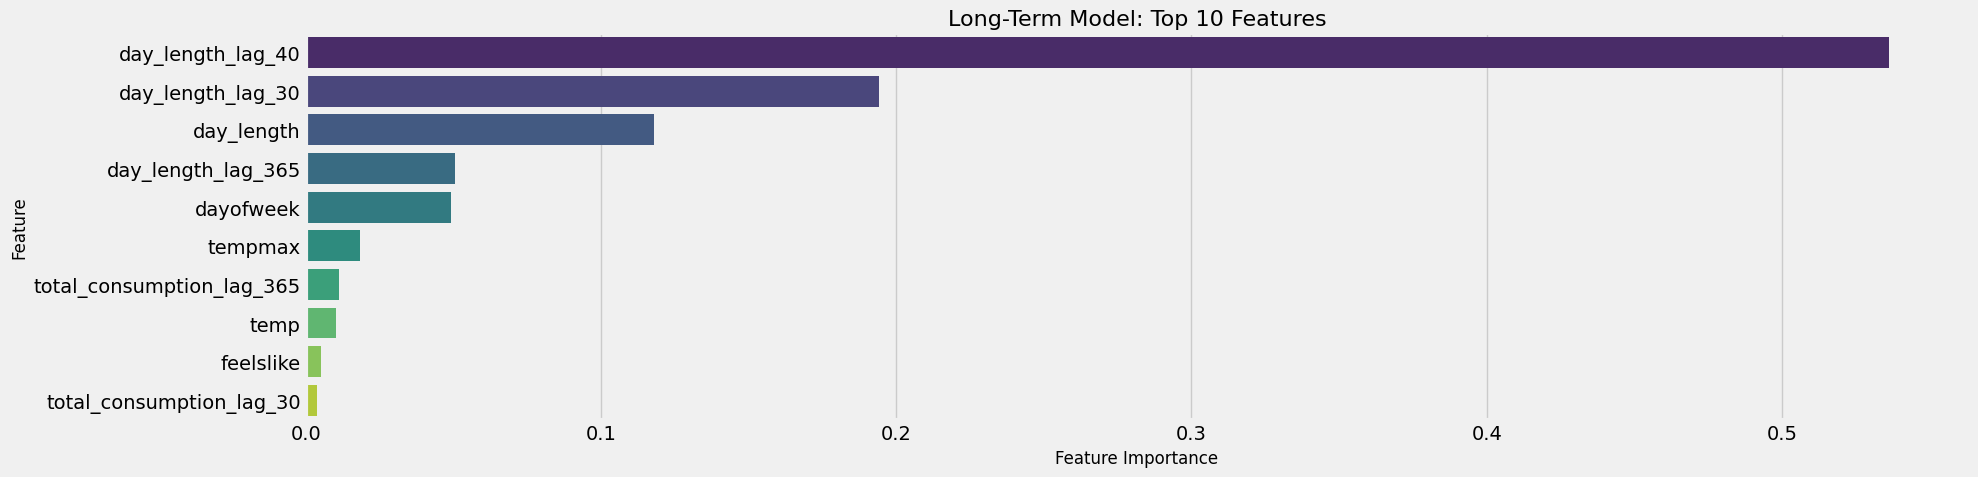

In [8]:
# Train the model on the 'weather_and_consumption_df' data
long_term_model = LongTermEnergyModel(weather_and_consumption_df)

# Plot the Feature Importance
long_term_model.plot_feature_importance(top_n=10)

In [9]:
# For long-term prediction
date = '2010-11-25'
long_term_prediction = long_term_model.predict_for_date(date)
print(f"Predicted total consumption for {date}: {long_term_prediction}")

Predicted total consumption for 2010-11-25: 1870.6547510472756


# <center><a id='1-Day'><span style="color:green">`1-Day` Vs. `30-Day` Model Future Predictions Comparison</span></a></center>

#### Train the models

In [10]:
# Train the model on the 'weather_and_consumption_df' data
short_term_model = ShortTermEnergyModel(weather_and_consumption_df)

# Train the model on the 'weather_and_consumption_df' data
long_term_model = LongTermEnergyModel(weather_and_consumption_df)

#### Genrate dates for Test

In [11]:
# Date range generation using pandas
date_range = pd.date_range(start='2009-05-17', end='2010-05-17', freq='D') 

# Initialize numpy arrays for error storage
long_term_errors = np.zeros(len(date_range))
short_term_errors = np.zeros(len(date_range))

#### Perform the Test

In [12]:
# Initialize a list for prediction storage
predictions = []

# Ensure your models and weather_and_consumption_df are properly defined above
for i, date in enumerate(tqdm(date_range, desc='Testing Models')):
    date_str = date.strftime('%Y-%m-%d')
    long_term_prediction = long_term_model.predict_for_date(date_str)
    short_term_prediction = short_term_model.predict_for_date(date_str)
    real_value = weather_and_consumption_df.loc[date_str, 'total_consumption']
    
    # Calculate and store errors
    long_term_errors[i] = long_term_prediction - real_value
    short_term_errors[i] = short_term_prediction - real_value
    
    # Store predictions
    predictions.append({
        'date': date,
        'long_term_prediction': long_term_prediction,
        'short_term_prediction': short_term_prediction,
        'real_value': real_value
    })

# Convert predictions to DataFrame for easier manipulation
predictions_df = pd.DataFrame(predictions)
predictions_df.set_index('date', inplace=True)

Testing Models: 100%|███████████████████████████████████████████████████████████████████████████████| 366/366 [00:27<00:00, 13.39it/s]


In [13]:
predictions_df.head(2)

,long_term_prediction,short_term_prediction,real_value
date,,,
2009-05-17,1550.179683,1598.678048,1543.764
2009-05-18,1511.923645,1494.204380,1209.906


#### Plot the result

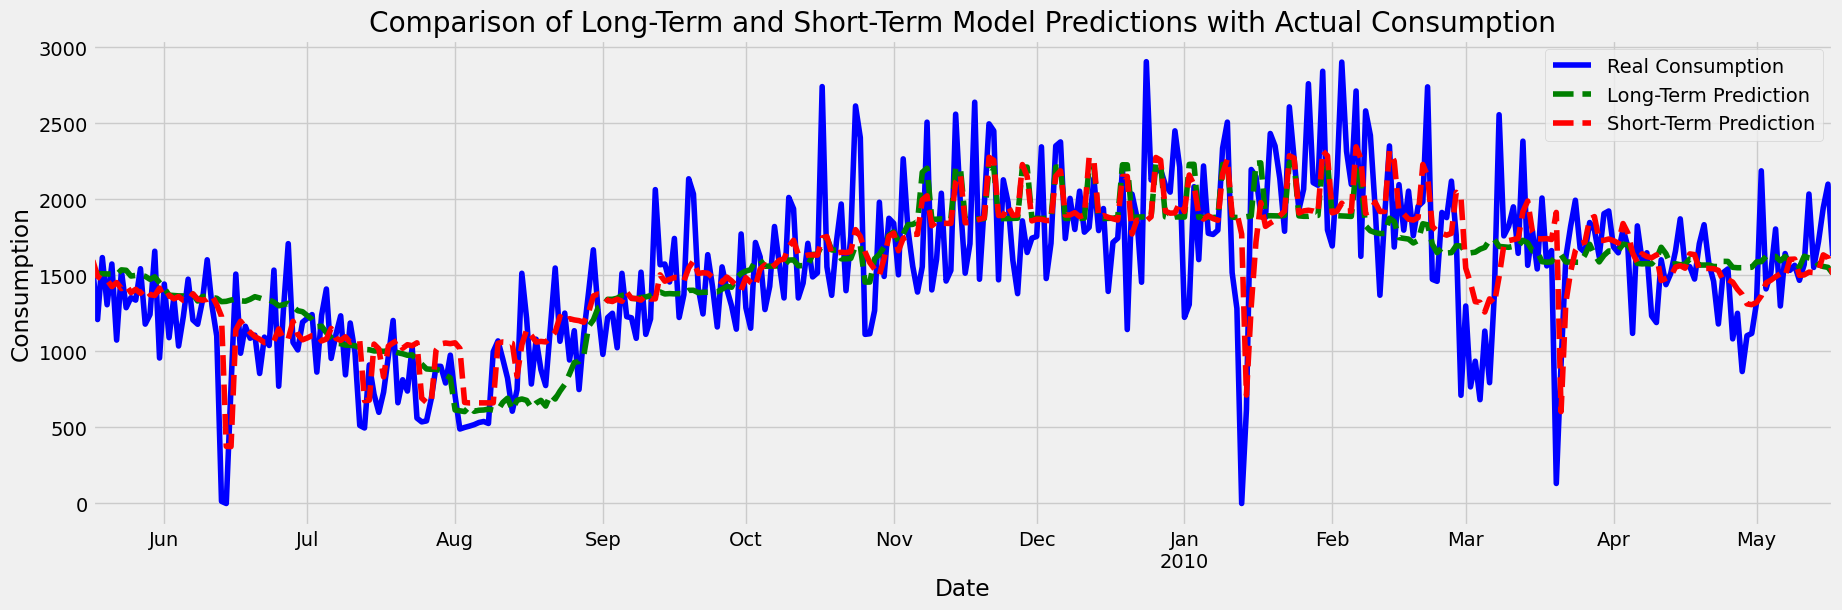

Long Term MAE: 279.76119573723196
Short Term MAE: 256.8164533135999


In [14]:
predictions_df[['real_value', 'long_term_prediction', 'short_term_prediction']].plot(figsize=(20, 6), style={'real_value': 'blue', 'long_term_prediction': '--g', 'short_term_prediction': '--r'}, title='Comparison of Long-Term and Short-Term Model Predictions with Actual Consumption')
plt.xlabel('Date')
plt.ylabel('Consumption')
plt.grid(True)
plt.legend(['Real Consumption', 'Long-Term Prediction', 'Short-Term Prediction'])

# Calculate mean absolute error using numpy
long_term_mae = np.mean(np.abs(long_term_errors))
short_term_mae = np.mean(np.abs(short_term_errors))

# Save the plot as an image file with a name that reflects the updated title
plt.savefig('../results/Long-Term_vs_Short-Term_Model_Predictions_Comparison_with_Actual_Consumption.png')

plt.show()

print(f'Long Term MAE: {long_term_mae}')
print(f'Short Term MAE: {short_term_mae}')

## Connect with me 🌐
<div align="center">
  <a href="https://www.linkedin.com/in/labrijisaad/">
    <img src="https://img.shields.io/badge/LinkedIn-%230077B5.svg?&style=for-the-badge&logo=linkedin&logoColor=white" alt="LinkedIn" style="margin-bottom: 5px;"/>
  </a>
  <a href="https://github.com/labrijisaad">
    <img src="https://img.shields.io/badge/GitHub-100000?style=for-the-badge&logo=github&logoColor=white" alt="GitHub" style="margin-bottom: 5px;"/>
  </a>
</div>